In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from g2p_en import G2p
import re
import torch.nn.utils as utils

import math

import pickle
import Levenshtein
import os

from IPython.display import Audio
import soundfile as sf

In [ ]:
"""
Open and check the data (DATA large-vocab). 
The data is presented as pickle files. 

DATA.pkl has emg recordings from 9660 sentences. Each EMG recording is of the shape (31, T), where 31 is the number
of sensor nodes and T is the number of time steps. EMG data is sampled at 5000 Hertz.

textLABELS.pkl has 9660 text labels corresponding to each entry in DATA.pkl

HuBERTLABELS.pkl has 9660 HuBERT units corresponding to each entry in DATA.pkl
These HuBERT units can be fed to the Tacotron vocoder to create audio corresponding to 
each entry in DATA.pkl
"""

In [2]:
DATA = pickle.load(open("/mnt/dataDrive/emg2Audio/cleanData/DATA.pkl", "rb"))
unitLABELS = np.load("/mnt/dataDrive/emg2Audio/cleanData/HuBERTLABELS.pkl", allow_pickle = True)
textLABELS = pickle.load(open("/mnt/dataDrive/emg2Audio/cleanData/textLABELS.pkl", "rb"))

In [3]:
print("Number of EMG recordings in large-vocabulary data:  ", len(DATA))
print("Shape of a EMG recording: ", DATA[0].shape)
print(" ")
print("Number of sentences: ", len(textLABELS))

Number of EMG recordings in large-vocabulary data:   9660
Shape of a EMG recording:  (31, 28533)
 
Number of sentences:  9660


In [4]:
"""
z-normalize the data along time-dimension for each entry.
"""

normDATA = []
for i in range(len(DATA)):
    Mean = np.mean(DATA[i], axis = -1)
    Std = np.std(DATA[i], axis = -1)
    normDATA.append((DATA[i] - Mean[..., np.newaxis])/Std[..., np.newaxis])

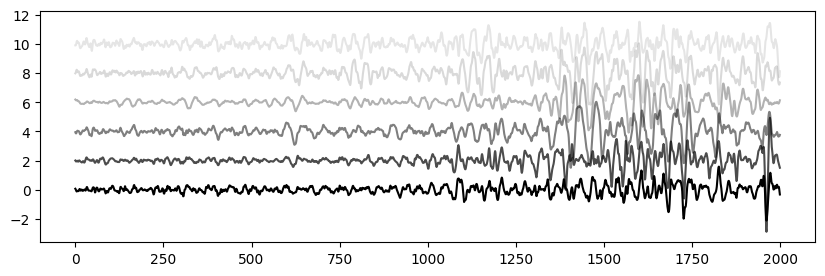

In [5]:
"""View a few EMG data segments."""

plt.figure(figsize = (10, 3))
plt.plot(normDATA[0][0, 500:2500], color = 'black')
plt.plot(normDATA[0][1, 500:2500] + 2, color = 'black', alpha = 0.7)
plt.plot(normDATA[0][2, 500:2500] + 4, color = 'black', alpha = 0.5)
plt.plot(normDATA[0][3, 500:2500] + 6, color = 'black', alpha = 0.3)
plt.plot(normDATA[0][4, 500:2500] + 8, color = 'black', alpha = 0.15)
plt.plot(normDATA[0][5, 500:2500] + 10, color = 'black', alpha = 0.1)
plt.show()

In [6]:
"""
Read the ground truth labels. First 8500 sentences are used for training, 
next 760 for validation, and the remaining 400 for test.
"""

for l in textLABELS:
    print(l)

nuclear rockets can destroy airfields with ease
the best way to learn is to solve extra problems
the spray will be used in first division matches next season
our experiments positive outcome was unexpected
alimony harms a divorced mans wealth
she uses both names interchangeably
the misquote was retracted with an apology
critics fear the erosion of consumer protections and environmental standards
her lips moist and parted spoke his name
how do they turn out later
the eastern coast is a place for pure pleasure and excitement
please make your decision wisely to visit the beach
she encouraged her children to make their own halloween costumes
cleaned cloth must be protected against the redeposition of dispersed soil
both figures would go higher in later years
she always jokes about too much garlic in his food
if people were more generous there would be no need for welfare
the dimensions of these waves dwarf all our usual standards of measurement
the knifelike pain in his groin nearly brough

In [10]:
"""
Confirm there is no data leakage.

Of the 400 sentences, there are 6 sentences which are same as in train and validation set. 
This occurred due to manual oversight during data curation. However, it is a very tiny fraction.
"""

count = 0
for i in range(400):
    if textLABELS[9260 + i] in textLABELS[:9260]:
        count += 1

print(count)

6


In [11]:
import sys, os
sys.path.insert(0, "/home/k2/src/textlesslib")  
import textless
print("textless loaded from:", textless.__file__)

import os, re, pathlib, torch, torchaudio
from textless.vocoders.tacotron2.vocoder import TacotronVocoder

device = "cuda" if torch.cuda.is_available() else "cpu"
vocoder = TacotronVocoder.by_name("hubert-base-ls960", "kmeans", 100).to(device)
srOut = vocoder.output_sample_rate
print("vocoder SR:", srOut, "| device:", device)

textless loaded from: /home/k2/src/textlesslib/textless/__init__.py
vocoder SR: 22050 | device: cuda


In [14]:
"""Listen to corresponding audio reconstructed from HuBERT units.
Note that this audio is generated by gTTS.
This audio is not synchronized to user EMG."""
units = torch.tensor(unitLABELS[0], dtype = torch.long, device = device)
wav = vocoder(units) 
Audio(wav.cpu().numpy(), rate = 22050)